# Итерационные методы для частичной задачи на  собственные значения

## PINVIT

- Идея - минимизировать отношение Релея
- Используем градиентный спуск предобусловленный матрицей $B = A - \sigma I$ 

$$ x_{k+1} = x_k - \tau_k B^{-1}(Ax_k - R(x_k)x_k) $$

In [98]:
import numpy as np
import scipy.sparse.linalg as spsplin
import scipy.sparse as spsp

def pinvit(A, x0, sigma, tau, num_iter, tol, inexact=True):
    n = A.shape[0]
    if inexact:
        splu = spsplin.spilu(A - sigma * spsp.eye(n))
    else:
        splu = spsplin.splu(A - sigma * spsp.eye(n))
    
#     splu = spsplin.splu(spsp.eye(n))
    x = x0.copy()
    conv = [x]
    for k in range(num_iter):
        lam = (x @ A @ x) / (x @ x)
        x = x - tau * splu.solve(A @ x - lam * x)
        conv.append(x)
        if np.linalg.norm(A @ x - lam * x) < tol:
            break
    return x, (x @ A @ x) / (x @ x), conv

def invit(A, x0, tau, num_iter, tol):
    n = A.shape[0]
    x = x0.copy()
    conv = [x]
    for k in range(num_iter):
        lam = (x @ A @ x) / (x @ x)
        x = x - 2 * tau * (A @ x - lam * x) / (x @ x)
        conv.append(x)
        if np.linalg.norm(A @ x - lam * x) < tol:
            break
    return x, (x @ A @ x) / (x @ x), conv

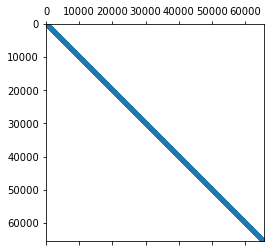

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline
n = 256
ex = np.ones(n)
lp1 = spsp.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr')
e = spsp.eye(n)
A = spsp.kron(lp1, e) + spsp.kron(e, lp1)
plt.spy(A, markersize=1)

In [100]:
true_eigval, true_eigvec = spsplin.eigsh(A, which="SM", k=1)
print(true_eigval)
x0 = np.random.randn(A.shape[0])
# x0 = np.ones(A.shape[0])
pinvit_eigvec, pinvit_eigval, conv_pinvit_inexact = pinvit(A, x0, 0, 1, 50, 1e-6, True)
print(pinvit_eigval)
pinvit_eigvec, pinvit_eigval, conv_pinvit_exact = pinvit(A, x0, 0, 1, 50, 1e-6, False)
print(pinvit_eigval)
invit_eigvec, invit_eigval, conv_invit = invit(A, x0, 40, 200, 1e-6)
print(invit_eigval)
# eigvals_all = np.linalg.eigvalsh(A.toarray())
# np.sort(eigvals_all)[50:]

[-0.00029885]
-0.000666678845291443
-0.00029885332106977913
-5.747387159537674


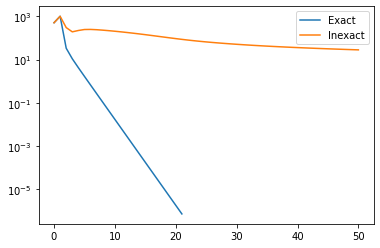

In [101]:
plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x / (x @ x)) for x in conv_pinvit_exact], label="Exact")
plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x / (x @ x)) for x in conv_pinvit_inexact], label="Inexact")
# plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x / (x @ x)) for x in conv_invit], label="Invit")
plt.legend()

In [102]:
def shift_inverse_iteration_fast(A, x0, num_iter, shift, tol):
    x = x0.copy()
    conv = [x]
    n = A.shape[0]
    splu = spsplin.splu(A - shift * spsp.eye(n))
    for i in range(num_iter):
        x = splu.solve(x)
        x = x / np.linalg.norm(x)
        conv.append(x)
        if np.linalg.norm(A @ x - x @ A @ x * x) < tol:
            break
    return x, conv

In [103]:
shift = 0.
num_iter = 100
tol=1e-6
middle_eigv, conv_m = shift_inverse_iteration_fast(A, x0, num_iter, shift, tol)
print(middle_eigv @ A @ middle_eigv)

-0.0002988543363461039


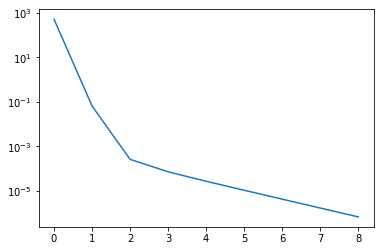

In [104]:
plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x / (x @ x)) for x in conv_m])

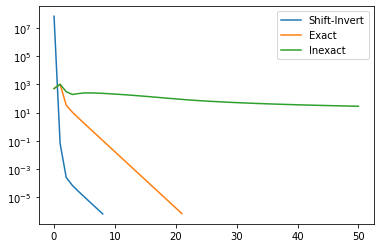

In [106]:
plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x) for x in conv_m], label="Shift-Invert")
plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x / (x @ x)) for x in conv_pinvit_exact], label="Exact")
plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x / (x @ x)) for x in conv_pinvit_inexact], label="Inexact")
plt.legend()

In [143]:
import scipy.sparse.linalg as spsplin

X = np.random.randn(A.shape[0], 1)
inc_lu = spsplin.spilu(A)
prec = spsplin.LinearOperator(A.shape, matvec=lambda x: inc_lu.solve(x))
eigenvalues, eigvect = spsplin.lobpcg(A, X, M=prec, tol=1e-6, largest=True, verbosityLevel=1, maxiter=900)

Solving standard eigenvalue problem with preconditioning

matrix size 65536
block size 1

No constraints


iteration 0
current block size: 1
eigenvalue: [-3.9984872]
residual norms: [1.99937588]
iteration 1
current block size: 1
eigenvalue: [-0.02293889]
residual norms: [0.1388527]
iteration 2
current block size: 1
eigenvalue: [-0.00191157]
residual norms: [0.0127397]
iteration 3
current block size: 1
eigenvalue: [-0.00144569]
residual norms: [0.00651077]
iteration 4
current block size: 1
eigenvalue: [-0.00135615]
residual norms: [0.00724466]
iteration 5
current block size: 1
eigenvalue: [-0.00122098]
residual norms: [0.00979996]
iteration 6
current block size: 1
eigenvalue: [-0.00111066]
residual norms: [0.0091979]
iteration 7
current block size: 1
eigenvalue: [-0.00100595]
residual norms: [0.00900598]
iteration 8
current block size: 1
eigenvalue: [-0.00092431]
residual norms: [0.00888124]
iteration 9
current block size: 1
eigenvalue: [-0.00085725]
residual norms: [0.00841982]
iterati

iteration 94
current block size: 1
eigenvalue: [-0.00041477]
residual norms: [0.00143957]
iteration 95
current block size: 1
eigenvalue: [-0.00041384]
residual norms: [0.00141635]
iteration 96
current block size: 1
eigenvalue: [-0.000413]
residual norms: [0.00140606]
iteration 97
current block size: 1
eigenvalue: [-0.0004121]
residual norms: [0.00138877]
iteration 98
current block size: 1
eigenvalue: [-0.00041127]
residual norms: [0.00140087]
iteration 99
current block size: 1
eigenvalue: [-0.00041037]
residual norms: [0.00140084]
iteration 100
current block size: 1
eigenvalue: [-0.00040953]
residual norms: [0.00140991]
iteration 101
current block size: 1
eigenvalue: [-0.00040863]
residual norms: [0.0013976]
iteration 102
current block size: 1
eigenvalue: [-0.00040781]
residual norms: [0.00139397]
iteration 103
current block size: 1
eigenvalue: [-0.00040693]
residual norms: [0.00137195]
iteration 104
current block size: 1
eigenvalue: [-0.00040614]
residual norms: [0.00136813]
iteration

iteration 189
current block size: 1
eigenvalue: [-0.00035029]
residual norms: [0.00105619]
iteration 190
current block size: 1
eigenvalue: [-0.00034979]
residual norms: [0.00104722]
iteration 191
current block size: 1
eigenvalue: [-0.0003493]
residual norms: [0.00106074]
iteration 192
current block size: 1
eigenvalue: [-0.0003488]
residual norms: [0.00104426]
iteration 193
current block size: 1
eigenvalue: [-0.00034832]
residual norms: [0.00104766]
iteration 194
current block size: 1
eigenvalue: [-0.00034783]
residual norms: [0.00102503]
iteration 195
current block size: 1
eigenvalue: [-0.00034737]
residual norms: [0.00103307]
iteration 196
current block size: 1
eigenvalue: [-0.00034689]
residual norms: [0.00102151]
iteration 197
current block size: 1
eigenvalue: [-0.00034643]
residual norms: [0.0010382]
iteration 198
current block size: 1
eigenvalue: [-0.00034594]
residual norms: [0.00102543]
iteration 199
current block size: 1
eigenvalue: [-0.00034548]
residual norms: [0.0010338]
ite

iteration 285
current block size: 1
eigenvalue: [-0.0003161]
residual norms: [0.00070306]
iteration 286
current block size: 1
eigenvalue: [-0.00031588]
residual norms: [0.00069046]
iteration 287
current block size: 1
eigenvalue: [-0.00031568]
residual norms: [0.00069284]
iteration 288
current block size: 1
eigenvalue: [-0.00031547]
residual norms: [0.00068341]
iteration 289
current block size: 1
eigenvalue: [-0.00031526]
residual norms: [0.00069057]
iteration 290
current block size: 1
eigenvalue: [-0.00031506]
residual norms: [0.00067933]
iteration 291
current block size: 1
eigenvalue: [-0.00031486]
residual norms: [0.00068273]
iteration 292
current block size: 1
eigenvalue: [-0.00031466]
residual norms: [0.00066397]
iteration 293
current block size: 1
eigenvalue: [-0.00031447]
residual norms: [0.00066764]
iteration 294
current block size: 1
eigenvalue: [-0.00031428]
residual norms: [0.0006528]
iteration 295
current block size: 1
eigenvalue: [-0.00031409]
residual norms: [0.00066369]
i

iteration 386
current block size: 1
eigenvalue: [-0.00030336]
residual norms: [0.00038208]
iteration 387
current block size: 1
eigenvalue: [-0.0003033]
residual norms: [0.0003888]
iteration 388
current block size: 1
eigenvalue: [-0.00030323]
residual norms: [0.00037952]
iteration 389
current block size: 1
eigenvalue: [-0.00030317]
residual norms: [0.0003831]
iteration 390
current block size: 1
eigenvalue: [-0.00030311]
residual norms: [0.00037241]
iteration 391
current block size: 1
eigenvalue: [-0.00030305]
residual norms: [0.00037428]
iteration 392
current block size: 1
eigenvalue: [-0.00030299]
residual norms: [0.00036471]
iteration 393
current block size: 1
eigenvalue: [-0.00030293]
residual norms: [0.00036859]
iteration 394
current block size: 1
eigenvalue: [-0.00030288]
residual norms: [0.0003625]
iteration 395
current block size: 1
eigenvalue: [-0.00030282]
residual norms: [0.00036629]
iteration 396
current block size: 1
eigenvalue: [-0.00030276]
residual norms: [0.00035792]
ite

iteration 485
current block size: 1
eigenvalue: [-0.00029999]
residual norms: [0.00019305]
iteration 486
current block size: 1
eigenvalue: [-0.00029997]
residual norms: [0.00019047]
iteration 487
current block size: 1
eigenvalue: [-0.00029995]
residual norms: [0.00019103]
iteration 488
current block size: 1
eigenvalue: [-0.00029994]
residual norms: [0.00018707]
iteration 489
current block size: 1
eigenvalue: [-0.00029992]
residual norms: [0.00018669]
iteration 490
current block size: 1
eigenvalue: [-0.00029991]
residual norms: [0.00018331]
iteration 491
current block size: 1
eigenvalue: [-0.00029989]
residual norms: [0.00018411]
iteration 492
current block size: 1
eigenvalue: [-0.00029988]
residual norms: [0.00018201]
iteration 493
current block size: 1
eigenvalue: [-0.00029986]
residual norms: [0.00018298]
iteration 494
current block size: 1
eigenvalue: [-0.00029985]
residual norms: [0.00018018]
iteration 495
current block size: 1
eigenvalue: [-0.00029984]
residual norms: [0.00017972]

iteration 585
current block size: 1
eigenvalue: [-0.00029914]
residual norms: [9.42542636e-05]
iteration 586
current block size: 1
eigenvalue: [-0.00029913]
residual norms: [9.48975925e-05]
iteration 587
current block size: 1
eigenvalue: [-0.00029913]
residual norms: [9.2217214e-05]
iteration 588
current block size: 1
eigenvalue: [-0.00029913]
residual norms: [9.28751765e-05]
iteration 589
current block size: 1
eigenvalue: [-0.00029912]
residual norms: [9.07506691e-05]
iteration 590
current block size: 1
eigenvalue: [-0.00029912]
residual norms: [9.21590811e-05]
iteration 591
current block size: 1
eigenvalue: [-0.00029912]
residual norms: [9.0251229e-05]
iteration 592
current block size: 1
eigenvalue: [-0.00029911]
residual norms: [9.1323958e-05]
iteration 593
current block size: 1
eigenvalue: [-0.00029911]
residual norms: [8.87655932e-05]
iteration 594
current block size: 1
eigenvalue: [-0.00029911]
residual norms: [8.9417134e-05]
iteration 595
current block size: 1
eigenvalue: [-0.00

iteration 683
current block size: 1
eigenvalue: [-0.00029893]
residual norms: [4.76483384e-05]
iteration 684
current block size: 1
eigenvalue: [-0.00029893]
residual norms: [4.90395039e-05]
iteration 685
current block size: 1
eigenvalue: [-0.00029893]
residual norms: [4.66638012e-05]
iteration 686
current block size: 1
eigenvalue: [-0.00029893]
residual norms: [4.80372854e-05]
iteration 687
current block size: 1
eigenvalue: [-0.00029893]
residual norms: [4.59224169e-05]
iteration 688
current block size: 1
eigenvalue: [-0.00029893]
residual norms: [4.76139145e-05]
iteration 689
current block size: 1
eigenvalue: [-0.00029893]
residual norms: [4.56886179e-05]
iteration 690
current block size: 1
eigenvalue: [-0.00029893]
residual norms: [4.72805557e-05]
iteration 691
current block size: 1
eigenvalue: [-0.00029892]
residual norms: [4.50313781e-05]
iteration 692
current block size: 1
eigenvalue: [-0.00029892]
residual norms: [4.63093052e-05]
iteration 693
current block size: 1
eigenvalue: [-

current block size: 1
eigenvalue: [-0.00029888]
residual norms: [2.65168967e-05]
iteration 772
current block size: 1
eigenvalue: [-0.00029888]
residual norms: [2.76731436e-05]
iteration 773
current block size: 1
eigenvalue: [-0.00029888]
residual norms: [2.64034517e-05]
iteration 774
current block size: 1
eigenvalue: [-0.00029888]
residual norms: [2.75082264e-05]
iteration 775
current block size: 1
eigenvalue: [-0.00029888]
residual norms: [2.60621104e-05]
iteration 776
current block size: 1
eigenvalue: [-0.00029888]
residual norms: [2.69700692e-05]
iteration 777
current block size: 1
eigenvalue: [-0.00029888]
residual norms: [2.55277232e-05]
iteration 778
current block size: 1
eigenvalue: [-0.00029888]
residual norms: [2.65531069e-05]
iteration 779
current block size: 1
eigenvalue: [-0.00029888]
residual norms: [2.53066317e-05]
iteration 780
current block size: 1
eigenvalue: [-0.00029888]
residual norms: [2.64272665e-05]
iteration 781
current block size: 1
eigenvalue: [-0.00029888]
re

iteration 865
current block size: 1
eigenvalue: [-0.00029886]
residual norms: [1.50839606e-05]
iteration 866
current block size: 1
eigenvalue: [-0.00029886]
residual norms: [1.55432301e-05]
iteration 867
current block size: 1
eigenvalue: [-0.00029886]
residual norms: [1.48132366e-05]
iteration 868
current block size: 1
eigenvalue: [-0.00029886]
residual norms: [1.52242449e-05]
iteration 869
current block size: 1
eigenvalue: [-0.00029886]
residual norms: [1.45797879e-05]
iteration 870
current block size: 1
eigenvalue: [-0.00029886]
residual norms: [1.50912032e-05]
iteration 871
current block size: 1
eigenvalue: [-0.00029886]
residual norms: [1.45227342e-05]
iteration 872
current block size: 1
eigenvalue: [-0.00029886]
residual norms: [1.50085429e-05]
iteration 873
current block size: 1
eigenvalue: [-0.00029886]
residual norms: [1.43652916e-05]
iteration 874
current block size: 1
eigenvalue: [-0.00029886]
residual norms: [1.47439231e-05]
iteration 875
current block size: 1
eigenvalue: [-

In [144]:
eigenvalues, eigvect.shape

(array([-0.00029886]), (65536, 1))

In [145]:
np.linalg.norm(A @ eigvect.ravel() - eigenvalues[0] * eigvect.ravel())

1.2204387566041562e-05